### Gabor/Gated Fourier Transform, also known as windowed Fourier transform or Short-Time Fourier Transform (STFT). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window

def gated_fourier_analysis(signal, window_size, hop_size, window_type='hann', fs=1.0, plot=False):
    """
    Perform Gated (Windowed) Fourier Analysis (STFT) on a 1D signal.

    Parameters:
    - signal (array-like): Input signal
    - window_size (int): Size of the analysis window
    - hop_size (int): Step size between successive windows
    - window_type (str): Type of window (e.g. 'hann', 'gaussian', 'hamming')
    - fs (float): Sampling frequency (for frequency axis)
    - plot (bool): If True, show the spectrogram

    Returns:
    - stft_matrix (2D np.array): Complex STFT matrix [freq, time]
    - freqs (1D np.array): Frequency axis
    - times (1D np.array): Time axis
    """

    signal = np.asarray(signal)
    window = get_window(window_type, window_size, fftbins=True)
    num_frames = 1 + (len(signal) - window_size) // hop_size
    stft_matrix = np.zeros((window_size // 2 + 1, num_frames), dtype=np.complex64)

    for i in range(num_frames):
        start = i * hop_size
        segment = signal[start:start + window_size]
        if len(segment) < window_size:
            segment = np.pad(segment, (0, window_size - len(segment)), mode='constant')

        windowed = segment * window
        spectrum = np.fft.rfft(windowed)
        stft_matrix[:, i] = spectrum

    freqs = np.fft.rfftfreq(window_size, d=1/fs)
    times = np.arange(num_frames) * hop_size / fs

    if plot:
        plt.figure(figsize=(10, 5))
        plt.pcolormesh(times, freqs, 20 * np.log10(np.abs(stft_matrix) + 1e-10), shading='gouraud')
        plt.title('Spectrogram (Gated Fourier Analysis)')
        plt.xlabel('Time [s]')
        plt.ylabel('Frequency [Hz]')
        plt.colorbar(label='Magnitude [dB]')
        plt.tight_layout()
        plt.show()

    return stft_matrix, freqs, times


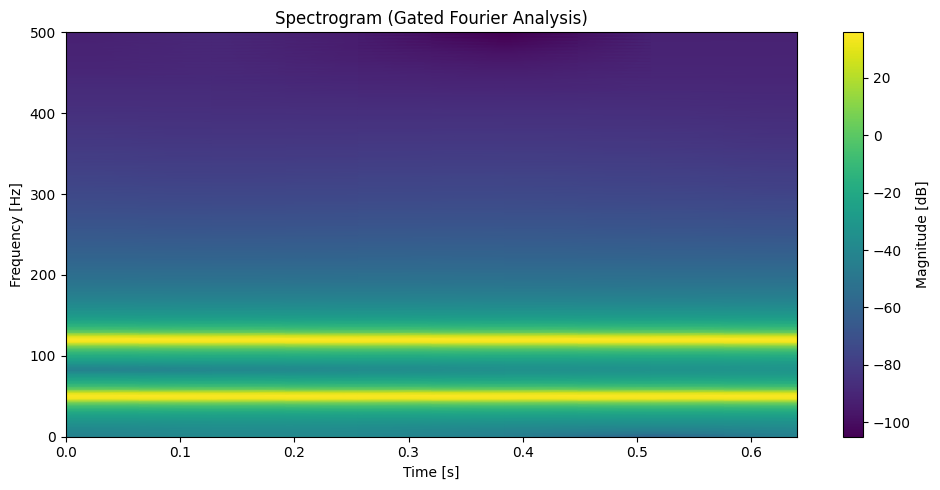

In [2]:
import numpy as np

# Example signal: 2 sinusoids
fs = 1000  # Sampling rate in Hz
t = np.linspace(0, 1, fs, endpoint=False)
signal = np.sin(2 * np.pi * 50 * t) + np.sin(2 * np.pi * 120 * t)

# Run gated Fourier analysis
stft_matrix, freqs, times = gated_fourier_analysis(signal, window_size=256, hop_size=128, fs=fs, plot=True)


### statistical thresholding

- Detects outliers based on a z-score threshold.

- Replaces outliers with interpolated values to keep the signal smooth.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def remove_outliers(signal, threshold=3.0, method='zscore', plot=False):
    """
    Remove outliers from a 1D signal using z-score or median-based thresholding.

    Parameters:
    - signal (array-like): Input noisy signal
    - threshold (float): Threshold value (e.g., 3.0 means 3 std deviations)
    - method (str): 'zscore' or 'iqr' for outlier detection
    - plot (bool): If True, show original vs cleaned signal

    Returns:
    - clean_signal (np.ndarray): Signal with outliers removed and interpolated
    """

    signal = np.asarray(signal)
    cleaned = signal.copy()

    if method == 'zscore':
        mean = np.mean(signal)
        std = np.std(signal)
        z_scores = np.abs((signal - mean) / std)
        outliers = z_scores > threshold

    elif method == 'iqr':
        q1, q3 = np.percentile(signal, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        outliers = (signal < lower_bound) | (signal > upper_bound)

    else:
        raise ValueError("method must be 'zscore' or 'iqr'")

    # Interpolate to replace outliers
    indices = np.arange(len(signal))
    good_indices = indices[~outliers]
    good_values = signal[~outliers]
    interpolator = interp1d(good_indices, good_values, kind='linear', fill_value='extrapolate')
    cleaned[outliers] = interpolator(indices[outliers])

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(signal, label='Original', alpha=0.6)
        plt.plot(cleaned, label='Cleaned', linewidth=2)
        plt.scatter(indices[outliers], signal[outliers], color='red', label='Outliers', zorder=5)
        plt.legend()
        plt.title('Outlier Removal from Signal')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return cleaned


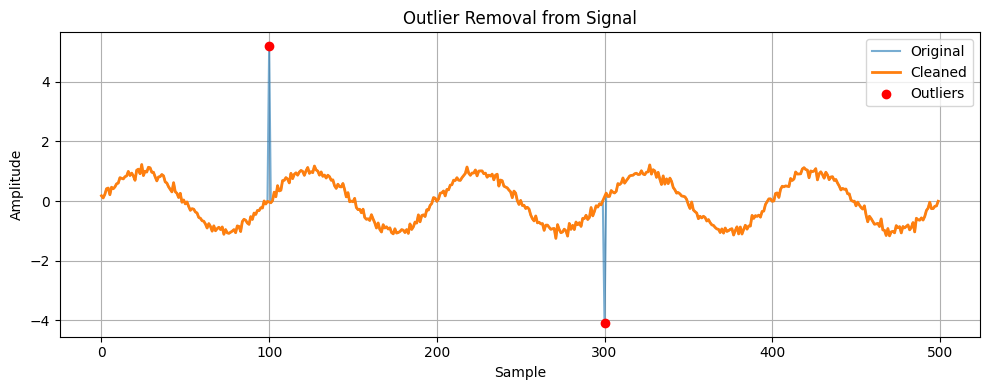

In [4]:
# Create a synthetic noisy signal with outliers
np.random.seed(0)
t = np.linspace(0, 1, 500)
signal = np.sin(2 * np.pi * 5 * t) + 0.1 * np.random.randn(500)
signal[100] += 5  # Outlier
signal[300] -= 4  # Another outlier

# Clean the signal
cleaned = remove_outliers(signal, threshold=3.0, method='zscore', plot=True)


### Goal
You have a 1D voltage signal (with time information), and you want to:

- Remove outliers (spikes that are not true voltage changes).

- Detect actual voltage jumps — i.e., significant changes in voltage that likely represent real events (like step changes or transitions).

- Return the time points at which those jumps occur.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

def remove_outliers(signal, threshold=3.0):
    """
    Removes outliers from a signal using z-score thresholding and linear interpolation.
    """
    signal = np.asarray(signal)
    mean = np.mean(signal)
    std = np.std(signal)
    z_scores = np.abs((signal - mean) / std)
    outliers = z_scores > threshold

    cleaned = signal.copy()
    indices = np.arange(len(signal))
    good_indices = indices[~outliers]
    good_values = signal[~outliers]

    interpolator = interp1d(good_indices, good_values, kind='linear', fill_value='extrapolate')
    cleaned[outliers] = interpolator(indices[outliers])
    return cleaned

def detect_voltage_jumps(time, voltage, threshold=0.5, outlier_z=3.0, plot=False):
    """
    Detects time points where significant voltage jumps occur.

    Parameters:
    - time (array): Time values
    - voltage (array): Voltage readings
    - threshold (float): Minimum change in voltage (delta) to count as a jump
    - outlier_z (float): Z-score threshold for outlier removal
    - plot (bool): Whether to show a plot

    Returns:
    - jump_times (array): Time points where jumps occurred
    """

    voltage = remove_outliers(voltage, threshold=outlier_z)

    # Compute first derivative (discrete difference)
    dV = np.diff(voltage)
    dT = np.diff(time)
    dV_dt = dV / dT

    # Detect points where voltage change exceeds threshold
    jump_indices = np.where(np.abs(dV) > threshold)[0]
    jump_times = time[jump_indices]

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(time, voltage, label='Cleaned Voltage')
        plt.plot(time[:-1], dV, label='dV', alpha=0.4)
        plt.scatter(jump_times, voltage[jump_indices], color='red', label='Voltage Jumps', zorder=5)
        plt.legend()
        plt.title('Detected Voltage Jumps')
        plt.xlabel('Time')
        plt.ylabel('Voltage')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return jump_times


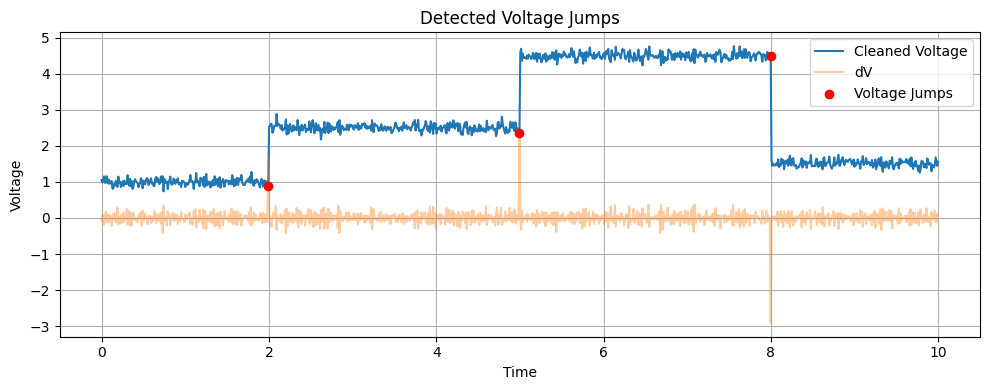

Detected voltage jump times: [1.99199199 4.99499499 7.997998  ]


In [6]:
# Simulated voltage signal with jumps
np.random.seed(42)
time = np.linspace(0, 10, 1000)
voltage = np.ones_like(time)
voltage[200:] += 1.5
voltage[500:] += 2.0
voltage[800:] -= 3.0
voltage += 0.1 * np.random.randn(len(voltage))  # Add noise
voltage[300] += 5  # Outlier spike

# Detect jumps
jumps = detect_voltage_jumps(time, voltage, threshold=0.5, outlier_z=3.0, plot=True)
print("Detected voltage jump times:", jumps)
